# Matrix Sensing

Let $X^*$ be an unknown rank-r symmetric positive semidefinite (PSD) matrix in $\mathbb{R}^{d\times d}$ that we aim
to recover. Assume this has unit 2-norm.

Let $A_1,\dots,A_m\in\mathbb{R}^{d\times d}$ be $m$ given (wlog) symmetric measurement matrices. We assume
that the label vector $y \in \mathbb{R}^m$ is generated by linear measurements
$$y_i = \langle A_i^\top, X^* \rangle = tr(A_i^T X^*)$$
We want to minimize the loss
$$L(U)=\frac{1}{m}\sum_{i=1}^m L_i(U),\quad  L_i(U) =\frac{1}{2}(y_i-\langle A_i, UU^\top\rangle)^2$$
for which 
$$\nabla L_i(U) = -2\cdot (y_i-\langle A_i, UU^\top \rangle)\cdot A_i U$$

In [41]:
import numpy as np
np.random.seed(42)
from numpy import linalg as la
import matplotlib.pyplot as plt
import sys
import random
import math
import seaborn as sns
import random
from tqdm import tqdm
colors = sns.color_palette("colorblind")
from scipy.linalg import sqrtm

In [42]:
import numpy as np
np.random.seed(42)
from numpy import linalg as la
import matplotlib.pyplot as plt
import seaborn as sns
colors = sns.color_palette("colorblind")
from scipy.linalg import sqrtm

In [43]:
def cost(U, A_vec, y):
    X = U@U.T
    return la.norm(y-A_vec@X.flatten())**2/(2*A_vec.shape[0])


def grad(U, A_vec, A, y):
    X = U@U.T
    grad = np.zeros(U.shape)
    for i in range(0,A_vec.shape[0]):
        grad = grad - 2*(y[i]-A_vec[i]@X.flatten())*(A[i]@U)
    return grad/A_vec.shape[0]

def GD(U0, eta, n_iter, A, A_vec, y):

    U=[U0]
    X=[U0@U0.T]
    C_Train = [cost(U0, A_vec, y)]
    for k in range(0,n_iter,1):
        U.append(U[k]-eta*grad(U[k], A_vec, A, y))
        X.append(U[-1]@U[-1].T)
        C_Train.append(cost(U[-1], A_vec, y))
        
    return U, X, C_Train


def PGD(U0, eta, n_iter, A, A_vec, y):

    U=[U0]
    X=[U0@U0.T]
    C_Train = [cost(U0, A_vec, y)]
    for k in range(0,n_iter,1):
        
        U_Unproj_New = U[k]-eta*grad(U[k], A_vec, A, y)
        X_Unproj_New = U_Unproj_New@U_Unproj_New.T
        X_Proj_New = proj(X_Unproj_New)
        U_Proj_New = sqrtm(X_Proj_New)
        
        U.append(U_Proj_New)
        X.append(X_Proj_New)
        C_Train.append(cost(U[-1], A_vec, y))
        
    return U, X, C_Train

def proj(M):
    
    """
    Implement the projection of a matrix on the semidefinite cone
    """
    # I found this algorithm in "Convex Optimization" by S.Boyd and L.Vandenberghe, page 399
    # Get the eigenvalue decomposition of X
    w, v = np.linalg.eigh(M)
    
    # Threshold the eigenvalues to ensure they are non-negative
    w = np.maximum(w, 0)
    
    # Reconstruct the positive semi-definite matrix from the thresholded eigenvalues and eigenvectors
    Y = v @ np.diag(w) @ v.T
    
    return Y
    

In [44]:

# problem settings
n = 30
U_rank = 5
num_samples = 100 # 5 * n * U_rank # 100
num_samples_test = 100 # 5 * n * U_rank # 100

# generating problem
np.random.seed(0)
U_sol = np.random.normal(0, 1, (n , U_rank))
U_sol = U_sol/la.norm(U_sol,2)
X_sol = U_sol@U_sol.T;

# training data
A_vec = np.zeros((num_samples,int(n*n)))
A = []
np.random.seed(0)
for i in range(num_samples):
    A_i= np.random.normal(0, 1, (n , n))
    A.append((A_i+A_i.T)/2)
    A_vec[i,:] = A[i].flatten()
    
y = A_vec@X_sol.flatten()
y = A_vec@X_sol.flatten()+1*np.random.normal(0, 1, y.shape)

In [45]:
eta=0.01
n_iter = 100

U0 = np.random.normal(0, 1/np.sqrt(n), (n , n))

U, X, C_Train = GD(U0, eta, n_iter, A, A_vec, y)
U_P, X_P, C_Train_P = PGD(U0, eta, n_iter, A, A_vec, y)

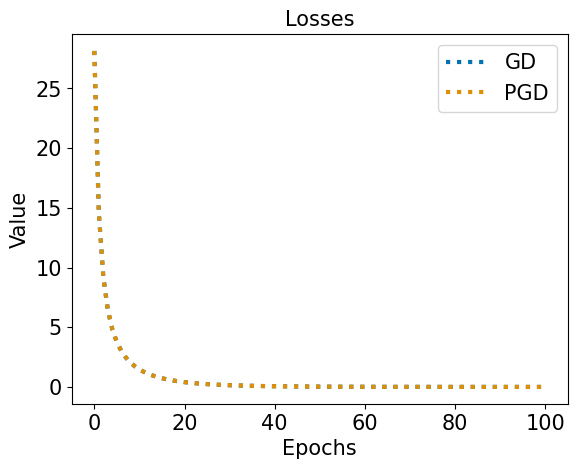

In [46]:
plt.figure()
# We plot
line_1, = plt.plot(range(0,n_iter+1),C_Train, color = colors[0],linewidth=3, linestyle='dotted')
line_2, = plt.plot(range(0,n_iter+1),C_Train_P, color = colors[1],linewidth=3, linestyle='dotted')
plt.legend([ line_1,line_2], ['GD', 'PGD'],fontsize=15)
plt.title("Losses",fontsize=15)
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('Value',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()  